In [1]:
!pip install -q transformers

# !pip install -q google

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 36.9 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 


## Select working directory

In [ ]:
# %cd ../input/newdata

In [49]:
import tensorflow as tf
import logging
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import re
import random
from sklearn.utils import shuffle

In [50]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.65.227.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.227.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Select Data Directory!

### Use google colab

In [51]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "/content/gdrive/Shareddrives/Shared/NLP_Final/dataset/"
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/19080pKGbnbJm4nmj1UCKqoDt3kuPBSIk/NLP_Final/dataset
bert_pretrained.mdl  fixed_train.gsheet  NewData/     tweetData.csv
fixed_test.csv       fixed_valid.csv     Origin/
fixed_test.gsheet    fixed_valid.gsheet  Prompt/
fixed_train.csv      LongDialogues/      TextATextB/


### Relative directory from this ipynb

In [52]:
%cd NewData

/content/gdrive/.shortcut-targets-by-id/19080pKGbnbJm4nmj1UCKqoDt3kuPBSIk/NLP_Final/dataset/NewData


## Build the model

In [53]:
max_length = 512
batch_size = 32
dev_size = 0.1
num_class = 32


In [54]:
from transformers import GPT2Tokenizer, TFGPT2Model
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer,TFAutoModel



from transformers import AutoTokenizer

model_name = "Nakul24/RoBERTa-emotion-classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [55]:
data_train = pd.read_csv('new_train.csv', encoding='utf-8')
data_test = pd.read_csv('new_test.csv', encoding='utf-8')
data_valid = pd.read_csv('new_valid.csv', encoding='utf-8')

data_train['text'] = data_train['prompt'] + " " + data_train['utterance']
data_test['text'] = data_test['prompt'] + " " + data_test['utterance']
data_valid['text'] = data_valid['prompt'] + " " + data_valid['utterance']

X_train = data_train.text.tolist()
X_test = data_test.text.tolist()
X_valid = data_valid.text.tolist()

y_train = data_train.label.tolist()
# y_test = data_test.label.tolist()
y_valid = data_valid.label.tolist()

data = data_train.append(data_test, ignore_index=True)

# class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']
class_names = [i for i in range(32)]

print('size of training set: %s' % (len(data_train['text'])))
print('size of validation set: %s' % (len(data_valid['text'])))
print('size of test set: %s' % (len(data_test['text'])))
# print(data.Emotion.value_counts())

# X_train


size of training set: 19533
size of validation set: 2770
size of test set: 2547


## If the valid acc is high enough, add valid data and train again before sumbittion.

In [30]:
# submit
data_train = pd.concat([data_train, data_valid], axis=0)
data_train = shuffle(data_train)
X_train = data_train.text.tolist()
y_train = data_train.label.tolist()
print('size of training set: %s' % (len(data_train['text'])))

size of training set: 22303


In [ ]:
# X_train[0]

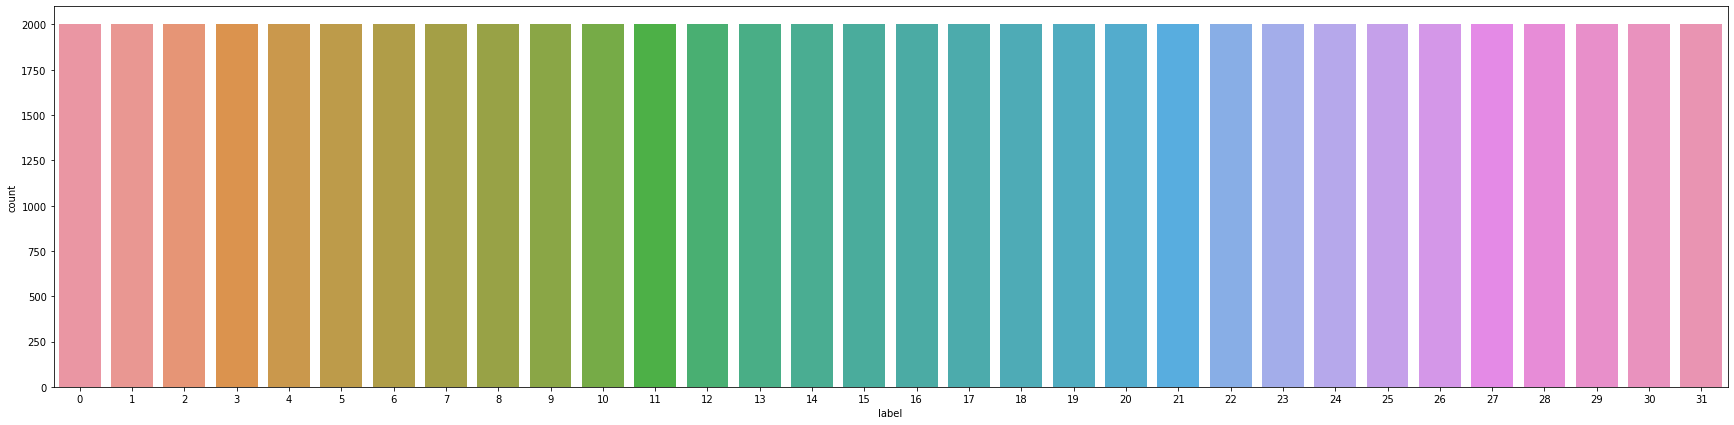

In [56]:
from sklearn.utils import shuffle
data_train.label.value_counts()
ListColumns = data_train.columns.tolist()

from sklearn.utils import resample
targetNum = 2000

newTrainFrame = pd.DataFrame(columns=ListColumns)
for i in range(32):
  # print("class : " + str(i))
    one_class_data = data_train[data_train.label == (i)] 
    ham_downsample = resample(one_class_data,
             replace=True,
             n_samples=(targetNum-len(one_class_data)),
             random_state=42)
    newTrainFrame = newTrainFrame.append(one_class_data, ignore_index = True)
    newTrainFrame = newTrainFrame.append(ham_downsample, ignore_index = True)
countplt, ax = plt.subplots(figsize = (30,7))
ax =sns.countplot(x = 'label', data=newTrainFrame)
newTrainFrame.groupby("label").count().mean()
newTrainFrame = shuffle(newTrainFrame)

data_train = newTrainFrame
X_train = newTrainFrame.text.tolist()
y_train = newTrainFrame.label.tolist()


# print(len(X_train))

In [57]:
def bert_encode(data):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokens = tokenizer.batch_encode_plus(
        data, max_length=max_length, padding="max_length", truncation=True
    )
    return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(X_train)
valid_encoded = bert_encode(X_valid)
train_labels = tf.keras.utils.to_categorical(data_train.label.values, num_classes=num_class)
valid_labels = tf.keras.utils.to_categorical(data_valid.label.values, num_classes=num_class)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, train_labels))
    .shuffle(100)
    .batch(batch_size)
).cache()
dev_dataset = (
    tf.data.Dataset.from_tensor_slices((valid_encoded, valid_labels))
    .shuffle(100)
    .batch(batch_size)
).cache()


In [58]:
def bert_tweets_model():
    bert_encoder = TFAutoModel.from_pretrained(model_name, output_attentions=True, from_pt=True)
    input_word_ids = Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]
    clf_output = Flatten()(last_hidden_states)
#     net = Dense(512, activation="relu")(clf_output)
#     net = Dropout(0.3)(net)
#     net = Dense(440, activation="relu")(net)
#     net = Dropout(0.3)(net)
    output = Dense(num_class, activation="softplus")(clf_output)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [59]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(
        loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"]
    )
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 tf_roberta_model_2 (TFRober  TFBaseModelOutputWithPoo  124645632
 taModel)                    lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             512),                               
                              (None, 12, None, 512),       

In [60]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=1,
    validation_data=dev_dataset,
    verbose=1,
)

2000/2000 [==============================] - 443s 180ms/step - loss: 1.0835 - accuracy: 0.6401 - val_loss: 1.1792 - val_accuracy: 0.6563


In [ ]:
test_encoded = bert_encode(X_test)
test_dataset = tf.data.Dataset.from_tensor_slices(test_encoded).batch(batch_size)
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = np.argmax(predicted_tweets, axis=-1)

In [ ]:
# model.save_weights('/kaggle/working/weights.h5', overwrite=True)


In [ ]:
my_submission = pd.DataFrame({"ID": data_test.conv_id, "label": predicted_tweets_binary})

In [ ]:
# my_submission.to_csv("/kaggle/working/PredictResult5.csv")
my_submission



,ID,label
0,hit:0_conv:0,25
1,hit:10025_conv:20050,9
2,hit:10036_conv:20072,17
3,hit:10039_conv:20079,5
4,hit:10040_conv:20080,1
...,...,...
2542,hit:9947_conv:19895,22
2543,hit:9965_conv:19931,17
2544,hit:9985_conv:19971,8
2545,hit:9987_conv:19974,10


## Need to convert it as Submission format 
## We convert the predictions on Google colab, the code is following.

In [ ]:
# predict result 
# data_test.to_csv("perfect.csv")

#origin test.csv
fixed_test = pd.read_csv("../fixed_test.csv")

# data_test = pd.read_csv("PredictResult6.csv")
data_test = my_submission

# create new dataframe
pred = pd.DataFrame(columns=['conv_id', 'pred'])

for i in tqdm(range(fixed_test.shape[0])):
  for j in range(data_test.shape[0]):
    if fixed_test['conv_id'][i] == data_test['ID'][j]:
      pred = pred.append({"conv_id" : fixed_test['conv_id'][i], "pred" : data_test["label"][j]}, ignore_index=True)
      break;
pred = pred.iloc[: , 1:]
pred.pred = pred.pred.astype(int)
pred.to_csv('Pred.csv')

100%|██████████| 10973/10973 [03:19<00:00, 55.04it/s]
